In [1]:
import pandas as pd
import gensim
import spacy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
from gensim.corpora.dictionary import Dictionary
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from gensim.models.word2vec import Word2Vec, LineSentence
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

In [2]:
claims = pd.read_csv('/Users/rabram/Desktop/NSS/dq-9-finding-the-at-fault-party-with-claims-nlp-manta-rays/data/NSS_DS_data.thegeneral.csv')

In [3]:
claims.head()

,ClaimID_RGEN,ExposureID_RGEN,ClaimLevelBody,ExposureLevelBody,AccidentDescription,InjuryDescription,DamageDescription,SeverityTypeName,ClaimGroup,FaultRatingName,LossCauseName,CCCreateTime,CloseDate,StateName
0,10000,131005,reviewed\r\ncoverage sc rated policy and loss...,none none liability accepted by adverse and da...,the insured was test driving a vehicle the ov...,neckback,front left side damages towed collision tow i...,Moderate,Tampa Field Ops,Other party at fault,Collision with motor vehicle,2015-03-12 09:05:17.9100000,2015-04-29 11:25:18.3190000,South Carolina
1,10001,131006,c dol *******\r\n tol *** pm\r\n v...,c coverage\r\ndol *****\r\nfnol ***** by ni \...,the iv was driving down the road when the ov i...,pain,front right headlight front side of bumper dr...,Minor,Tampa Field Ops,Other party at fault,Collision while merging / lane change,2015-03-12 11:46:23.1590000,2015-07-06 08:26:47.5350000,Florida
2,10002,131007,insured was in the hospital and lost service ...,none none c coverage\r\ndol *****\r\nfnol ***...,insured was stopped at the stop light when cv ...,strain,unknown damages rear bumper trunk right rear ...,Minor,Tampa Field Ops,Other party at fault,Rear-end collision,2015-03-12 13:12:35.4440000,2017-11-20 14:17:39.0910000,Florida
3,10003,131008,insured was in the hospital and lost service ...,none none hhcsi dos ****** atd for brant willi...,insured was stopped at the stop light when cv ...,back,unknown damages rear bumper trunk right rear ...,NaN,Tampa Field Ops,Other party at fault,Rear-end collision,2015-03-12 13:12:35.4440000,2017-11-20 14:17:39.0910000,Florida
4,10004,131009,adjuster out of office\r\nreassigned adjuster ...,new pip loss received additional action neede...,ov re host veh,neck back,none none none,Minor,Fast Track,Other party at fault,Collision with motor vehicle,2015-03-12 16:35:17.3570000,2016-01-29 13:54:25.6150000,Florida


In [4]:
explore_claims = claims.drop_duplicates('CCCreateTime')

In [5]:
explore_claims['CloseDate'] = pd.to_datetime(explore_claims['CloseDate'])
explore_claims['CCCreateTime'] = pd.to_datetime(explore_claims['CCCreateTime'])

In [6]:
explore_claims['elapsedTime'] = explore_claims['CloseDate'] - explore_claims['CCCreateTime']

In [7]:
explore_claims['Damage_length'] = explore_claims.DamageDescription.str.len()

In [8]:
explore_claims['accident_length'] = explore_claims.AccidentDescription.str.len()

In [9]:
explore_claims['claim_length'] = explore_claims.ClaimLevelBody.str.len()

In [10]:
explore_claims.head()

,ClaimID_RGEN,ExposureID_RGEN,ClaimLevelBody,ExposureLevelBody,AccidentDescription,InjuryDescription,DamageDescription,SeverityTypeName,ClaimGroup,FaultRatingName,LossCauseName,CCCreateTime,CloseDate,StateName,elapsedTime,Damage_length,accident_length,claim_length
0,10000,131005,reviewed\r\ncoverage sc rated policy and loss...,none none liability accepted by adverse and da...,the insured was test driving a vehicle the ov...,neckback,front left side damages towed collision tow i...,Moderate,Tampa Field Ops,Other party at fault,Collision with motor vehicle,2015-03-12 09:05:17.910,2015-04-29 11:25:18.319,South Carolina,48 days 02:20:00.409000,103,87,25653
1,10001,131006,c dol *******\r\n tol *** pm\r\n v...,c coverage\r\ndol *****\r\nfnol ***** by ni \...,the iv was driving down the road when the ov i...,pain,front right headlight front side of bumper dr...,Minor,Tampa Field Ops,Other party at fault,Collision while merging / lane change,2015-03-12 11:46:23.159,2015-07-06 08:26:47.535,Florida,115 days 20:40:24.376000,182,121,10354
2,10002,131007,insured was in the hospital and lost service ...,none none c coverage\r\ndol *****\r\nfnol ***...,insured was stopped at the stop light when cv ...,strain,unknown damages rear bumper trunk right rear ...,Minor,Tampa Field Ops,Other party at fault,Rear-end collision,2015-03-12 13:12:35.444,2017-11-20 14:17:39.091,Florida,984 days 01:05:03.647000,51,59,14052
4,10004,131009,adjuster out of office\r\nreassigned adjuster ...,new pip loss received additional action neede...,ov re host veh,neck back,none none none,Minor,Fast Track,Other party at fault,Collision with motor vehicle,2015-03-12 16:35:17.357,2016-01-29 13:54:25.615,Florida,322 days 21:19:08.258000,14,14,22670
6,10006,131011,clear\r\n\r\nsiu claim\r\n\r\ncov cov issue ...,none none demand recd for clmt brockman\r\nlet...,cv was going through the traffic light and iv ...,back pain,front right side damaged head lights hood is d...,Minor,Atlanta Casualty Ops,Insured at fault,Collision in an intersection,2015-03-13 10:36:54.474,2016-05-23 13:07:36.184,South Carolina,437 days 02:30:41.710000,177,115,33279


In [11]:
explore_claims['elapsed_days']=explore_claims.elapsedTime.dt.total_seconds() / (3600*24)

In [12]:
explore_claims['elapsed_hours']=explore_claims.elapsedTime.dt.total_seconds() / (3600)

In [13]:
grouped = explore_claims.groupby('FaultRatingName')

In [20]:
df = pd.DataFrame(grouped.AccidentDescription.value_counts())

In [25]:
df.loc[df.AccidentDescription > 5]

AccidentDescription
FaultRatingName        AccidentDescription                                                    
Comparative Negligence iv rear ended cv                                                      8
                       iv struck a pedestrian                                                6
                       received med clm for ins no accident details pr...                    6
Fault unknown          iv rear ended cv                                                      9
                       cv rear ended iv                                                      6
Insured at fault       iv rear ended cv                                                   1223
                       iv re cv                                                            329
                       cv was stopped at a red light when iv rear ende...                  262
                       iv rear ended ov                                                    213
                       iv rear ended ov at red light                                       187
                       iv rear ended ov in traffic                                         182
                       iv rearended cv                                                     163
                       cv was stopped at traffic light and iv rear end...                   93
                       iv rear ended cv in traffic                                          83
                       cv was stopped in traffic when iv rear ended cv                      82
                       cv was stopped at a light when iv rear ended cv                      73
                       cv was stopped at red light when iv rear ended cv                    67
                       iv rear ended the cv                                                 61
                       iv rear ended cv at a traffic light                                  58
                       iv rear ended cv at a red light                                      55
                       cv was stopped at a traffic light and iv rear e...                   51
                       iv rear ended ov in stopped traffic                                  49
                       iv rear end cv                                                       48
                       iv rear ended cv at a stop light                                     48
                       cv was stopped at traffic light when iv rearend...                   47
                       insured rear ended ov                                                44
                       iv ran a stop sign and struck cv                                     43
                       iv rear ended cv in heavy traffic                                    41
                       cv was stopped at a stop sign when iv rear ende...                   39
                       cv was stopped at traffic light when iv rear en...                   39
...                                                                                        ...
Other party at fault   cv re iv at a stop light                                              7
                       cv rear ended iv in traffic lane                                      7
                       cv rear ended iv who was stopped at a red light                       7
                       cv rear ended the iv                                                  7
                       cv rear ended vnop                                                    7
                       cv* rear ended cv* pushing cv* into iv                                7
                       cv* rearended iv causing iv to rearend cv*                            7
                       iv was at a stop light when cv rear ended iv                          7
                       iv was driving and cv changed lanes and struck iv                     7
                       iv was stopped at traffic light and was rear en...            

In [60]:
grouped.claim_length.mean()

FaultRatingName
Comparative Negligence    21035.060413
Fault unknown             10377.448471
Insured at fault          15321.545506
No fault                   9529.070079
Other party at fault      13133.605582
Name: claim_length, dtype: float64

In [63]:
grouped.elapsed_days.mean()

FaultRatingName
Comparative Negligence    261.003644
Fault unknown              85.670695
Insured at fault          205.131255
No fault                   96.734891
Other party at fault      195.713058
Name: elapsed_days, dtype: float64

In [67]:
length = pd.DataFrame(grouped.claim_length.mean()).reset_index()
length

,FaultRatingName,claim_length
0,Comparative Negligence,21035.060413
1,Fault unknown,10377.448471
2,Insured at fault,15321.545506
3,No fault,9529.070079
4,Other party at fault,13133.605582


In [68]:
days = pd.DataFrame(grouped.elapsed_days.mean()).reset_index()
days

,FaultRatingName,elapsed_days
0,Comparative Negligence,261.003644
1,Fault unknown,85.670695
2,Insured at fault,205.131255
3,No fault,96.734891
4,Other party at fault,195.713058


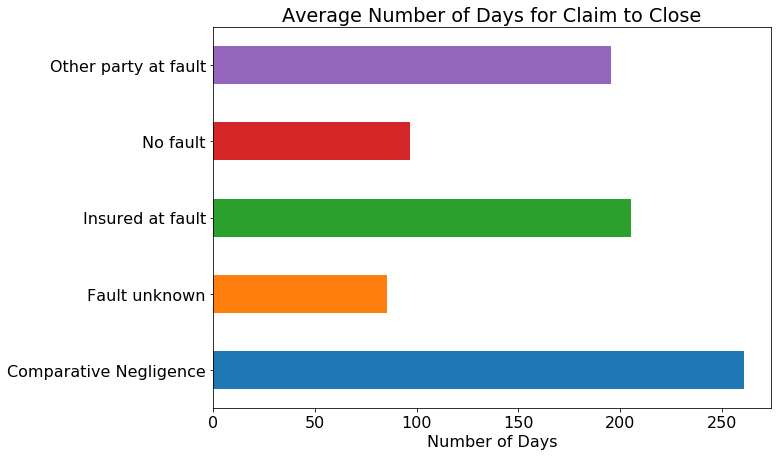

In [73]:
plt.rcParams.update({'font.size': 16})
days.plot.barh(x='FaultRatingName', y='elapsed_days', rot=0, title ='Average Number of Days for Claim to Close', legend = False, 
                          figsize = (10,7))
plt.xlabel("Number of Days")
plt.ylabel('');


In [74]:
days['cost'] = days['elapsed_days'] * 100

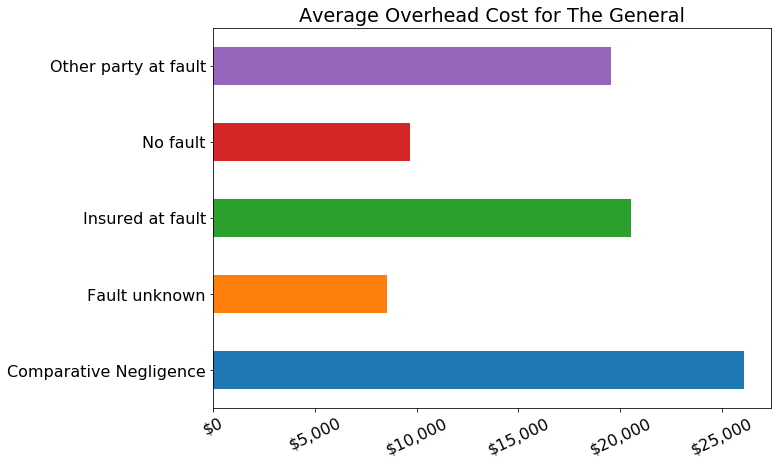

In [85]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
days.plot(kind='barh', x='FaultRatingName', y='cost',
        align='center', width=.5, edgecolor='none', ax=ax, legend = False, title='Average Overhead Cost for The General')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)
plt.ylabel('')
plt.show()
